# Работа с заботой, удовлетворенность сотрудников и их отток

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании (от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён). 

**Задача первая** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

**Задача вторая** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**Описание данных**

Данные содержат: 
id — уникальный идентификатор сотрудника;
dept — отдел, в котором работает сотрудник;
level — уровень занимаемой должности;
workload — уровень загруженности сотрудника;
employment_years — длительность работы в компании (в годах);
last_year_promo — показывает, было ли повышение за последний год;
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
salary — ежемесячная зарплата сотрудника;
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
quit — увольнение сотрудника из компании.

Файлы для первой задачи:

- Тренировочная выборка: train_job_satisfaction_rate.csv
- Входные признаки тестовой выборки: test_features.csv
- Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

Данные для второй задачи:
- Тренировочная выборка: train_quit.csv
- Входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv
- Целевой признак тестовой выборки: test_target_quit.csv

**Ход исследования**

    загрузка и обзор данных;
    предообработка данных;
    исследовательский анализ;
    корреляционный анализ;
    использование паплайнов и обучение моделей для предсказаний;
    написание итогового вывода.

### Импорт библиотек

In [1]:
# импортируем библиотеки
!pip install --upgrade scikit-learn>=1.3.1
!pip install phik -q
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import plotly.express as px
import sklearn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42

### Функции

In [2]:
def info_head(file):
    '''Информация о данных и первые 5 строк, переменная файл'''
    
    print("=== Информация о данных (info) ===")
    file.info()
    print("\n=== Первые 5 строк (head) ===")
    display(file.head())

In [3]:
def viewing_unique(file): 
    '''смотрим уникальные значения в столбцах, переменная файл'''

    list_object_columns = file.select_dtypes(include=['object']).columns.tolist()

    for col_l in list_object_columns:
        print('-'* 25)
        print(col_l, file[col_l].sort_values().unique())

In [4]:
def bar_and_box(file, col):
    '''функция для построения bar и ящика , переменные файл и категория'''

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
   
    sns.barplot(x=file[col].value_counts().index, y=file[col].value_counts().values, data=file, color='royalblue', ax=axes[0])
    axes[0].set_title(f'График Bar по {col}')
    axes[0].set_ylabel('Частота')
    axes[0].set_xlabel(col)
    
    # Boxplot
    sns.boxplot(x=file[col], ax=axes[1], color='royalblue')
    axes[1].set_title('Boxplot')
    
    plt.tight_layout()
    plt.show()

In [5]:
def hist_and_box(file, col):
    '''функция для построения гистограммы и ящика, переменные файл и категория'''
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Гистограмма
    sns.histplot(file[col], ax=axes[0], color='#B57EDC')
    axes[0].set_title(f'Гистограмма по "{col}"')
    axes[0].set_ylabel('Частота')
    axes[0].set_xlabel(col)

    # Boxplot
    sns.boxplot(x=file[col], ax=axes[1], color='#B57EDC')
    axes[1].set_title('Boxplot')
    
    plt.tight_layout()
    plt.show()

In [6]:
def diagram_pie(file):
    '''для построения круговой диаграммы категориальных признаков в файле, переменная файл'''
    
    list_object_columns = file.select_dtypes(include=['object']).columns.tolist()
    num_col = len(list_object_columns)
    plt.figure(figsize=(20, 5 * ((num_col + 1) // 2)))

    for i, column in enumerate(list_object_columns, 1):
        plt.subplot((num_col + 1) // 2, 3, i)
        file[column].value_counts().plot(
            kind= 'pie',
            colors=sns.color_palette('pastel')[0:5],
            autopct = "%.1f%%",
            ylabel= "",
            textprops={'fontsize': 14})
        plt.title(f'Соотношение по: "{column}"', fontsize=18)
    
    plt.tight_layout()
    plt.show()

In [7]:
def bar_and_box_category(file, category, values):
    '''для построения графика bar и ящика с разделением на 2 категории, переменные файл, категория, значения'''

    plt.figure(figsize=(12, 5))

    # Гистограмма
    plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
    sns.barplot(x=file[file[category] == 'no'][values].value_counts().index, 
                y=file[file[category] == 'no'][values].value_counts().values, 
                data=file[file[category] == 'no'], 
                color='royalblue', 
                alpha=0.5, 
                label='Остались')
    sns.barplot(x=file[file[category] == 'yes'][values].value_counts().index, 
                y=file[file[category] == 'yes'][values].value_counts().values, 
                data=file[file[category] == 'yes'], 
                color='orange', 
                alpha=0.5,
                label='Уволились')
    plt.title(f'Histogram: Остались vs Уволились, {values}')
    plt.xlabel(values)
    plt.ylabel('quantity')
    plt.legend()

    plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
    sns.boxplot(y=category, x=values, data=file,
                palette={'no': '#7F7FFF', 'yes': '#FFD17F'},
                order=['no', 'yes']
               )
    plt.title(f'Boxplot: Остались vs Уволились, {values}')
    plt.suptitle('')  # Удаляем автоматический заголовок
    plt.xlabel(values)
    plt.ylabel(category)
    plt.yticks([0, 1], ['Остались (no)', 'Уволились (yes)'])
        
    plt.tight_layout()  # Чтобы графики не накладывались
    plt.show()

In [8]:
def hist_and_box_category(file, category, values):
    '''для построения гистограммы и ящика с разделением на 2 категории, переменные файл, категория, значения'''

    plt.figure(figsize=(12, 5))

    # Гистограмма
    plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
    plt.hist(file[file[category] == 'no'][values], bins=20, alpha=0.5, label='Остались', color='blue')
    plt.hist(file[file[category] == 'yes'][values], bins=20, alpha=0.5, label='Уволились', color='orange')
    plt.title(f'Histogram: Остались vs Уволились, {values}')
    plt.xlabel(values)
    plt.ylabel('quantity')
    plt.legend()

    plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
    sns.boxplot(y=category, x=values, data=file,
                palette={'no': '#7F7FFF', 'yes': '#FFD17F'},
                order=['no', 'yes']
               )

    plt.title(f'Boxplot: Остались vs Уволились, {values}')
    plt.suptitle('')  # Удаляем автоматический заголовок
    plt.xlabel(values)
    plt.ylabel(category)
    plt.yticks([0, 1], ['Остались (no)', 'Уволились (yes)'])
    
    plt.tight_layout()  # Чтобы графики не накладывались
    plt.show()

In [9]:
def pie(file, col_1, col_2):
    '''для построения круговой диаграммы категориальных признаков в файле, переменная файл, две категории'''
    
    file = file.copy()
    file['Количество'] = 1
            
    fig = px.sunburst(
        file,
        path=[col_1, col_2],
        values='Количество',
        title=f"Диаграмма по категориям {col_1} и {col_2}",
        width=750, height=350)

    fig.update_traces(
        textinfo='label+percent parent',  # Процент от родительской категории
        insidetextorientation='horizontal',
        hovertemplate='<b>%{label}</b><br>Количество: %{value}<br>Доля: %{percentParent:.2%}',
        texttemplate='<b>%{label}</b><br>%{percentParent:.2%}')

    fig.update_layout(
        margin=dict(t=50, l=0, r=0, b=0))  # Отступы от краев

    fig.show()

## Задача 1: предсказание уровня удовлетворённости сотрудника.

### Загрузка данных

In [10]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv') # прочитаем файл

In [11]:
info_head(train_job)

=== Информация о данных (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

=== Первые 5 строк (head) ===


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [13]:
X_test_rate = pd.read_csv('/datasets/test_features.csv') # прочитаем файл

In [14]:
info_head(X_test_rate)

=== Информация о данных (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

=== Первые 5 строк (head) ===


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [15]:
y_test_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv') # прочитаем файл

In [16]:
info_head(y_test_rate)

=== Информация о данных (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

=== Первые 5 строк (head) ===


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод:**

Файл 'train_job'(тренировочная выборка) содержит информацию о 4000 сотрудников, отделе, должности, загруженности, длительности, повышении, нарушениях, оценке от руководителя, зарплате, уровню удовлетворенности. Есть несколько пропусков в двух столбцах, тип данных соответствует норме, нужно проверить столбцы на ошибки и строки на наличие дубликатов.

Файл 'X_test_rate'(тестовая выборка) содержит информацию о 2000 сотрудников, отделе, должности, загруженности, длительности, повышении, нарушениях, оценке от руководителя, зарплате. Есть несколько пропусков в двух столбцах, тип данных соответствует норме, нужно проверить столбцы на ошибки и строки на наличие дубликатов.

Файл 'y_test_rate' содержит информацию об уровне удовлетворенности 2000 сотрудников из тестовой выборки. Пропусков нет, тип данных соответствует норме.

Все файлы содержат столбец с 'id' сотрудника. Названия столбцов соответствуют 'змеиному регистру', порядок в файлах тестовых выборок по 'id' не совпадает.

### Предобработка данных

In [17]:
X_test_rate = X_test_rate.sort_values(by='id').reset_index(drop=True) #отсортируем строки по порядку 'id'
X_test_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [18]:
y_test_rate = y_test_rate.sort_values(by='id').reset_index(drop=True) #отсортируем строки по порядку 'id'
y_test_rate.head()

,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69


In [19]:
viewing_unique(train_job) # смотрим уникальные значения в столбцах через функцию

-------------------------
dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
-------------------------
level ['junior' 'middle' 'sinior' nan]
-------------------------
workload ['high' 'low' 'medium']
-------------------------
last_year_promo ['no' 'yes']
-------------------------
last_year_violations ['no' 'yes']


In [20]:
train_job['level'] = train_job['level'].replace('sinior', 'senior') # исправим ошибку

In [21]:
viewing_unique(X_test_rate) # смотрим уникальные значения в столбцах через функцию

-------------------------
dept [' ' 'hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
-------------------------
level ['junior' 'middle' 'sinior' nan]
-------------------------
workload [' ' 'high' 'low' 'medium']
-------------------------
last_year_promo ['no' 'yes']
-------------------------
last_year_violations ['no' 'yes']


In [22]:
X_test_rate['level'] = X_test_rate['level'].replace('sinior', 'senior') # исправим ошибку

In [23]:
#X_test_rate = X_test_rate.replace(' ', np.nan) # заменим пробелы на nan

In [24]:
print(train_job.duplicated().sum()) # посмотрим количество явных дубликатов
print(X_test_rate.duplicated().sum())
print(y_test_rate.duplicated().sum())

0
0
0


In [25]:
train_job.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


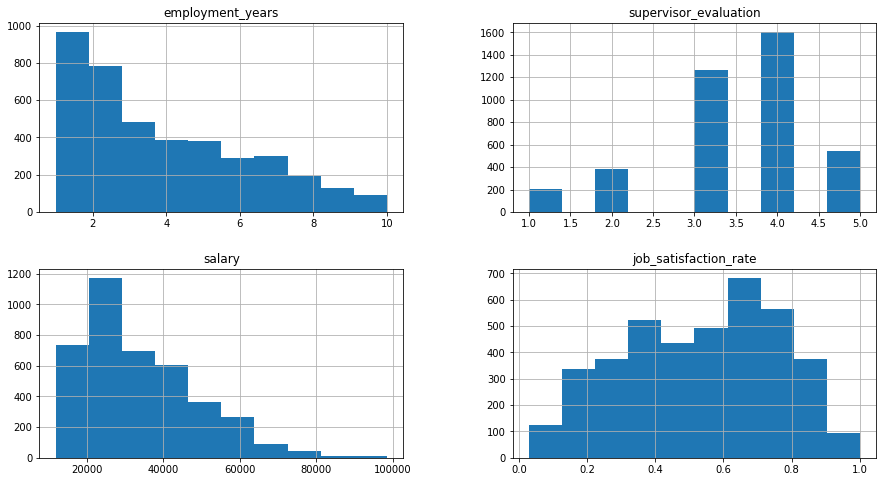

In [26]:
train_job.drop('id', axis=1).hist(figsize=(15, 8));

In [27]:
X_test_rate.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


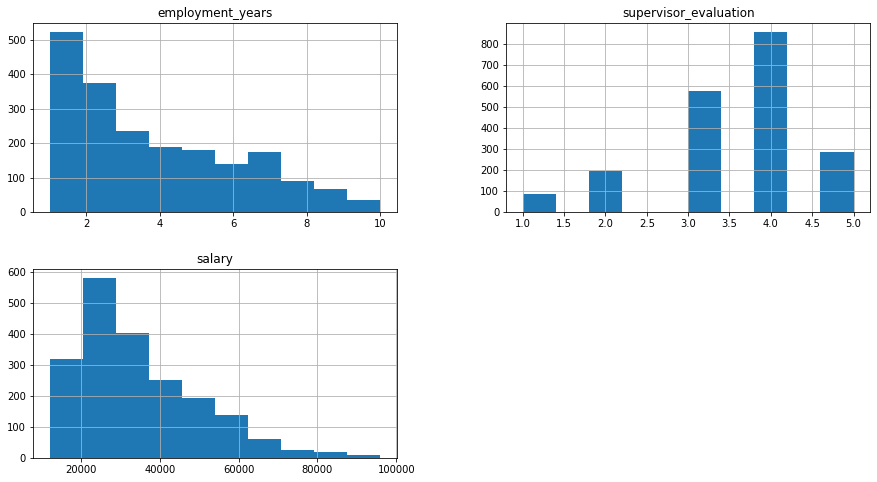

In [28]:
X_test_rate.drop('id', axis=1).hist(figsize=(15, 8));

In [29]:
y_test_rate.drop('id', axis=1).describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


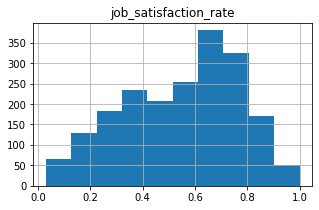

In [30]:
y_test_rate.drop('id', axis=1).hist(figsize=(5, 3));

**Вывод:**

В файле 'train_job' обнаружена ошибка в слове sinior, исправила на senior, есть пропущенные значения nan в столбцах dept и level.

В файле 'X_test_rate' обнаружена ошибка в слове sinior, исправила на senior, есть пропущенные значения nan и ' ' в столбцах dept, level, workload.

В файлах  'y_test_rate' и 'X_test_rate' сделала сортировку по 'id'. 

Во всех файлах явных дубликатов нет. Аномалий не обнаружено. Пропуски и пробелы nan заполним дальше через пайплайн.

### Исследовательский анализ данных

#### Файл train_job

In [31]:
train_job.drop('id', axis=1).describe() # оценим данные с количественными значениями

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


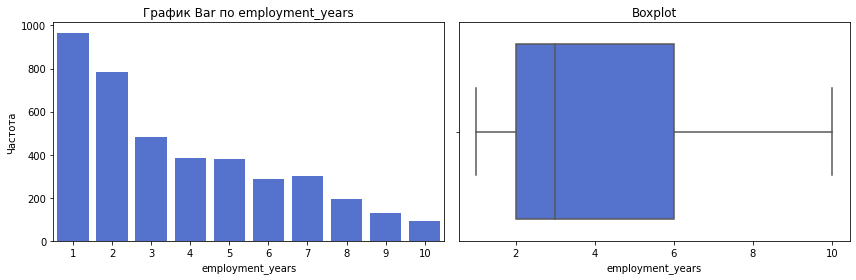

In [32]:
bar_and_box(train_job, 'employment_years') # построим barplot и boxplot через функцию

- **'employment_years'** распределение от большего количества сотрудников, тех кто работает 1 год до меньшего, кто работает 10 лет, среднее значение 3 года, основная часть в диапазоне 2 - 6 лет; на boxplot выбросов нет.

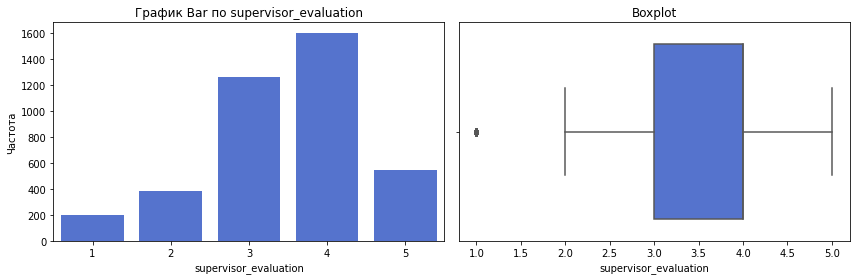

In [33]:
bar_and_box(train_job, 'supervisor_evaluation') # построим barplot и boxplot через функцию

- **'supervisor_evaluation'** распределение оценки руководителя от 1 до 5 баллов, среднее значение 4, основная часть в диапозоне 3 - 4; на boxplot заметен выброс равный 1.

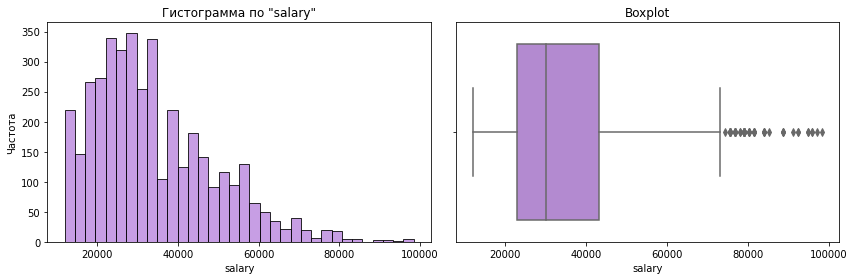

In [34]:
hist_and_box(train_job, 'salary') # построим гистограмму и boxplot через функцию

- **'salary'** распределение близко к нормальному, есть перекос влево, засчет большого количества более низких зарплат, среднее значение 30'000, основная часть в диапазоне 22'800 - 43'200; на boxplot заметны выбросы от 70'000 до 100'000.

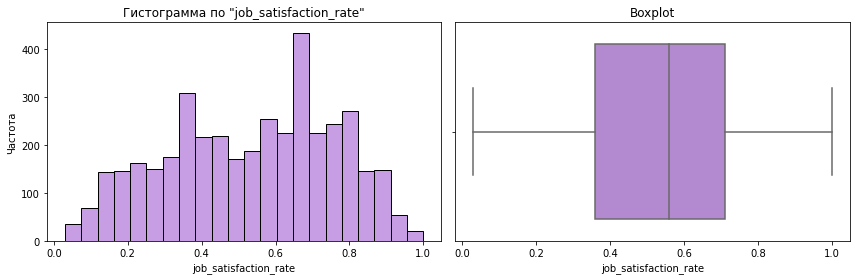

In [35]:
hist_and_box(train_job, 'job_satisfaction_rate') # построим гистограмму и boxplot через функцию

- **'job_satisfaction_rate'** распределение уровня удовлетворенности близко к нормальному, есть два пика около 0.35 и 0.70, среднее значение 0.56, основная часть в диапазоне 0.36 - 0.71; на boxplot выбросов нет.

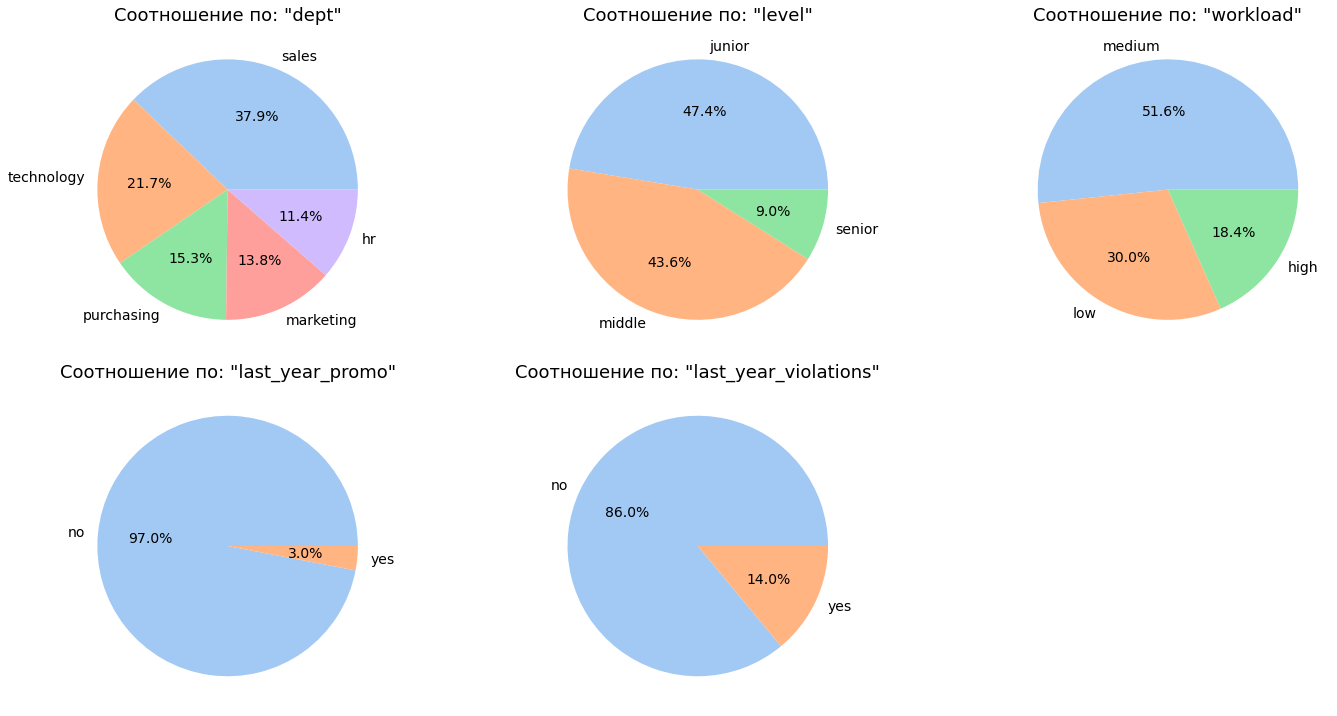

In [36]:
diagram_pie(train_job) # построим круговые диаграммы через функцию

Соотношение по категориальным признакам:
- 'dept' большая часть сотрудников работает в отделе 'sales' - 38%, 'technology' - 22%, 'purchasing' - 15%, 'marketing' - 14%, 'hr' - 11%; 
- 'level' большая часть сотрудников занимает уровнь 'junior' - 47%, 'middle' - 44%, 'senior' - 9%;
- 'workload' у большей части сотрудников нагрузка 'medium' - 52%, 'low' - 30%, 'high - 18%;
- 'last_year_promo' за год повышение было только у 3% сотрудников, у 97% повышения не было.
- 'last_year_violations' не нарушили трудовой договор 86% сотрудников, 14% нарушали.

#### Файл X_test_rate

In [37]:
X_test_rate.select_dtypes(exclude=['object']).columns.tolist()

['id', 'employment_years', 'supervisor_evaluation', 'salary']

In [38]:
X_test_rate.drop('id', axis=1).describe() # оценим данные с количественными значениями

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


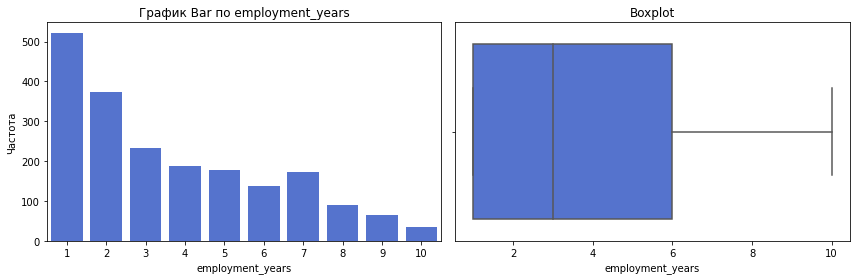

In [39]:
bar_and_box(X_test_rate, 'employment_years') # построим barplot и boxplot через функцию

- **'employment_years'** распределение в среднем от большего количества сотрудников, тех кто работает 1 год до меньшего, кто работает 10 лет, среднее значение 3 года, основная часть в диапазоне 1 - 6 лет; на boxplot выбросов нет.

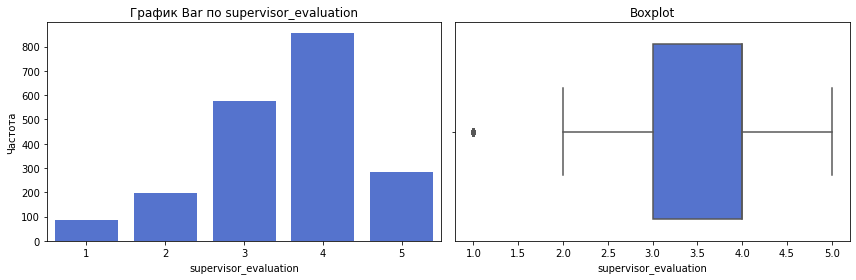

In [40]:
bar_and_box(X_test_rate, 'supervisor_evaluation') # построим barplot и boxplot через функцию

- **'supervisor_evaluation'** распределение оценки руководителя от 1 до 5 баллов, среднее значение 4, основная часть в диапазоне 3 - 4; на boxplot заметен выброс равный 1.

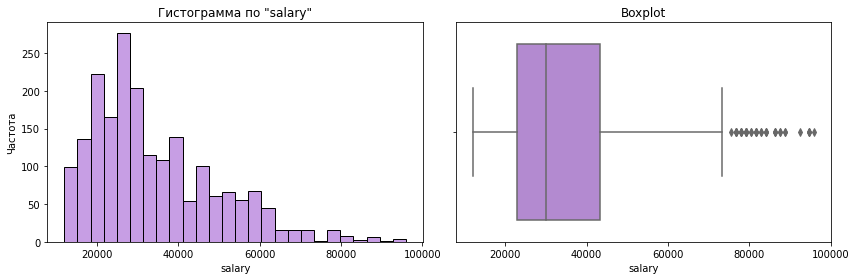

In [41]:
hist_and_box(X_test_rate, 'salary') # построим гистограмму и boxplot через функцию

- **'salary'** распределение близко к нормальному, есть перекос влево, засчет большого количества более низких зарплат, среднее значение 30'000, основная часть в диапазоне 22'800 - 43'200 лет; на boxplot заметны выбросы от 70'000 до 100'000.

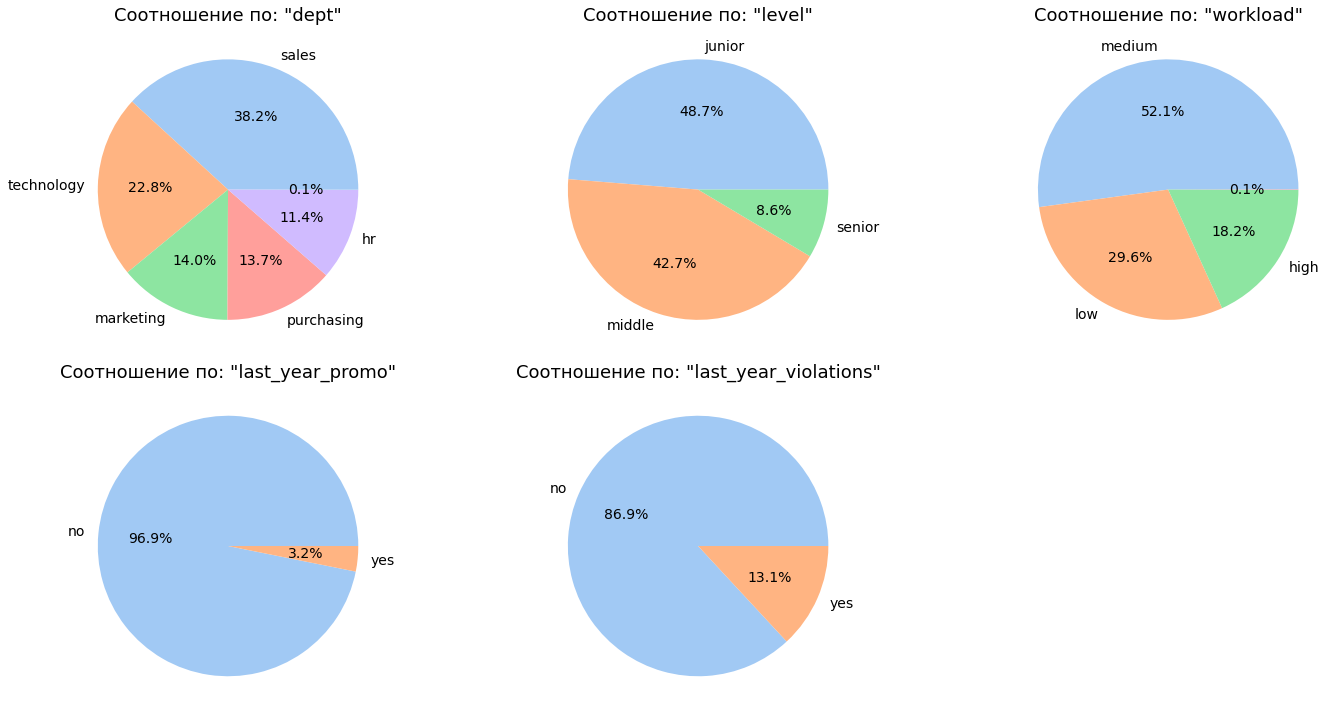

In [42]:
diagram_pie(X_test_rate) # построим круговые диаграммы через функцию

Соотношение по категориальным признакам:
- 'dept' большая часть сотрудников работает в отделе 'sales' - 38%, 'technology' - 23%, 'purchasing' - 14%, 'marketing' - 14%, 'hr' - 11%; 0.1% - пропущенные значения;
- 'level' большая часть сотрудников занимает уровнь 'junior' - 49%, 'middle' - 43%, 'senior' - 9%;
- 'workload' у большей части сотрудников нагрузка 'medium' - 52%, 'low' - 30%, 'high - 18%; 0.1% - пропущенные значения;
- 'last_year_promo' за год повышение было только у 3% сотрудников, у 97% повышения не было.
- 'last_year_violations' не нарушили трудовой договор 87% сотрудников, 13% нарушали.

#### Файл y_test

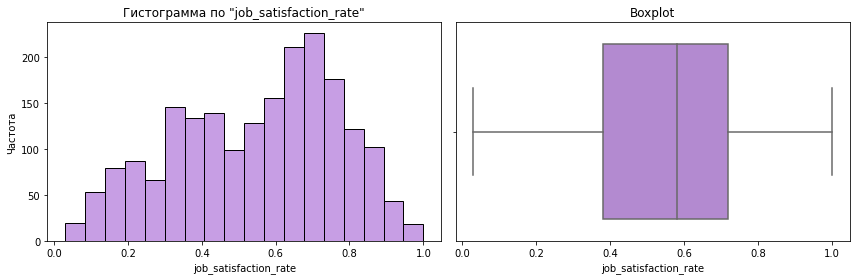

In [43]:
hist_and_box(y_test_rate, 'job_satisfaction_rate') # построим гистограмму и boxplot через функцию

In [44]:
y_test_rate.drop('id', axis=1).describe() # оценим данные с количественными значениями

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


- **'job_satisfaction_rate'** распределение уровня удовлетворенности близко к нормальному, есть два пика около 0.4 и 0.70, среднее значение 0.58, основная часть в диапазоне 0.38 - 0.72; на boxplot выбросов нет.

**Вывод:**

Данные разделены на выборки равномерно, средние значения и разделение на категории соответствуют.

### Корреляционный анализ

In [45]:
list_no_object_columns = train_job.drop('id', axis=1).select_dtypes(exclude=['object']).columns.tolist()
list_no_object_columns
train_job.columns.tolist()

['id',
 'dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

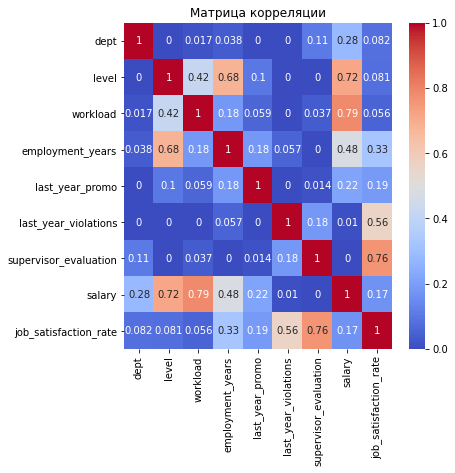

In [46]:
corr_matrix = train_job.drop('id', axis=1).phik_matrix(interval_cols=list_no_object_columns)
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Согласно шкале Чеддока и коэффициентам корреляции определена взаимосвязь целевого признака 'job_satisfaction_rate' со следующими признаками:

- сильная  зависимость (0.7 - 0.9)
        'supervisor_evaluation' оценка руководителя  (corr=0.76)

- средняя зависимость (0.5 - 0.7)
        'last_year_violations' нарушение договора (corr=0.56)
        
- слабая зависимость (0.3 - 0.5)
        employment_years длительность работы (corr= 0.33)

- очень слабая зависимость (0 - 0.3)
        'dept' отдел (corr= 0.082)
        'level' должность (corr= 0.081)
        'workload' загруженность (corr= 0.056)
        'last_year_promo' повышение (corr= 0.019)
        'salary' зарплата (corr= 0.17)

### Подготовка данных

In [47]:
train = train_job.drop(columns='id', axis=1)
train.duplicated().sum() # проверим наличие явных дубликатов

245

In [48]:
train = train.drop_duplicates() # удалим дубликаты

In [49]:
# подготовим выборки
X_train = train.drop('job_satisfaction_rate', axis=1)
y_train = train['job_satisfaction_rate']
X_test = X_test_rate.drop(columns='id', axis=1)
y_test = y_test_rate['job_satisfaction_rate']

In [50]:
X_train.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000


In [51]:
X_train.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary'],
      dtype='object')

In [52]:
ohe_columns = [
    'dept', 
    'last_year_promo', 
    'last_year_violations'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary'
]

In [53]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [54]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [55]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [56]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [57]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

### Обучение моделей и создание метрики SMAPE

In [58]:
# создание метрики
def make_SMAPE(y_true, y_pred):
    '''метрика SMAPE, переменные y_true, y_pred'''
    
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
                         
SMAPE = make_scorer(make_SMAPE, greater_is_better=False)

In [59]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring=SMAPE, 
    n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(make_SMAPE, greater_is_better=False, response_method='predict'))

In [60]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid.cv_results_)
result[['rank_test_score', #'param_models',
        'mean_test_score','params', 
#        'param_models__max_depth',
#        'param_preprocessor__num'
       ]].sort_values('rank_test_score').head(10)

,rank_test_score,mean_test_score,params
34,1,-15.708997,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'preprocessor__num': MinMaxScaler()}"
35,2,-15.751844,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'preprocessor__num': 'passthrough'}"
31,3,-15.758233,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 12, 'preprocessor__num': MinMaxScaler()}"
33,4,-15.767713,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'preprocessor__num': StandardScaler()}"
32,5,-15.777388,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 12, 'preprocessor__num': 'passthrough'}"
30,6,-15.778117,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 12, 'preprocessor__num': StandardScaler()}"
37,7,-15.866104,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'preprocessor__num': MinMaxScaler()}"
38,8,-15.882592,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'preprocessor__num': 'passthrough'}"
36,9,-15.934286,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'preprocessor__num': StandardScaler()}"
28,10,-15.959810,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 11, 'preprocessor__num': MinMaxScaler()}"


In [61]:
grid.best_params_

{'models': DecisionTreeRegressor(random_state=42),
 'models__max_depth': 13,
 'preprocessor__num': MinMaxScaler()}

In [62]:
'Метрика SMAPE для лучшей модели:\n', round(abs(grid.best_score_), 2)

('Метрика SMAPE для лучшей модели:\n', 15.71)

In [63]:
y_pred = grid.predict(X_test)
f'Метрика SMAPE на тестовой выборке: {round(make_SMAPE(y_test, y_pred), 2)}'

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Метрика SMAPE на тестовой выборке: 14.43'

**Выводы:**

- Заполнили пропуски в данных через Пайплайн
- Была выбрана лучшая модель из двух LinearRegression и DecisionTreeRegressor с созданной метрикой SMAPE, её параметры - DecisionTreeRegressor(max_depth=13, random_state=42),  'models__max_depth': 13, скайлер: MinMaxScaler()
- Значение метрики SMAPE на тестовой выборке составило 14.43.

DecisionTreeRegressor, показало лучшие результаты по сравнению с линейной регрессией потому что:
- зависимость между признаками нелинейная
- менее чувствительна к выбросам (были небольшие выбросы в данных)

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [241]:
train_quit = pd.read_csv('/datasets/train_quit.csv') # прочитаем файл

In [242]:
info_head(train_quit)

=== Информация о данных (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

=== Первые 5 строк (head) ===


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [243]:
X_test_quit = X_test_rate
info_head(X_test_quit)

=== Информация о данных (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

=== Первые 5 строк (head) ===


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [244]:
y_test_quit = pd.read_csv('/datasets/test_target_quit.csv') # прочитаем файл

In [245]:
info_head(y_test_quit)

=== Информация о данных (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

=== Первые 5 строк (head) ===


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Вывод:**

Файл 'train_quit'(тренировочная выборка) содержит информацию о 4000 сотрудников, отделе, должности, загруженности, длительности, повышении, нарушениях, оценке от руководителя, зарплате, увольнению. Пропусков нет, тип данных соответствует норме, нужно проверить столбцы на ошибки и строки на наличие дубликатов.

Файл 'X_test_quit'(тестовая выборка) содержит информацию о 2000 сотрудников, отделе, должности, загруженности, длительности, повышении, нарушениях, оценке от руководителя, зарплате. Есть несколько пропусков в двух столбцах, тип данных соответствует норме.

Файл 'y_test_quit' содержит информацию об уровне удовлетворенности 2000 сотрудников из тестовой выборки. Пропусков нет, тип данных соответствует норме.

Названия столбцов соответствуют 'змеиному регистру'.

### Предобработка данных

In [246]:
X_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [247]:
y_test_quit = y_test_quit.sort_values(by='id').reset_index(drop=True) #отсортируем строки по порядку 'id'
y_test_quit.head()

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


In [248]:
viewing_unique(train_quit) # смотрим уникальные значения в столбцах через функцию

-------------------------
dept ['hr' 'marketing' 'purchasing' 'sales' 'technology']
-------------------------
level ['junior' 'middle' 'sinior']
-------------------------
workload ['high' 'low' 'medium']
-------------------------
last_year_promo ['no' 'yes']
-------------------------
last_year_violations ['no' 'yes']
-------------------------
quit ['no' 'yes']


In [249]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior') # исправим ошибку

In [250]:
print(train_quit.duplicated().sum()) # посмотрим количество явных дубликатов
print(X_test_quit.duplicated().sum())
print(y_test_quit.duplicated().sum())

0
0
0


In [251]:
train_quit.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


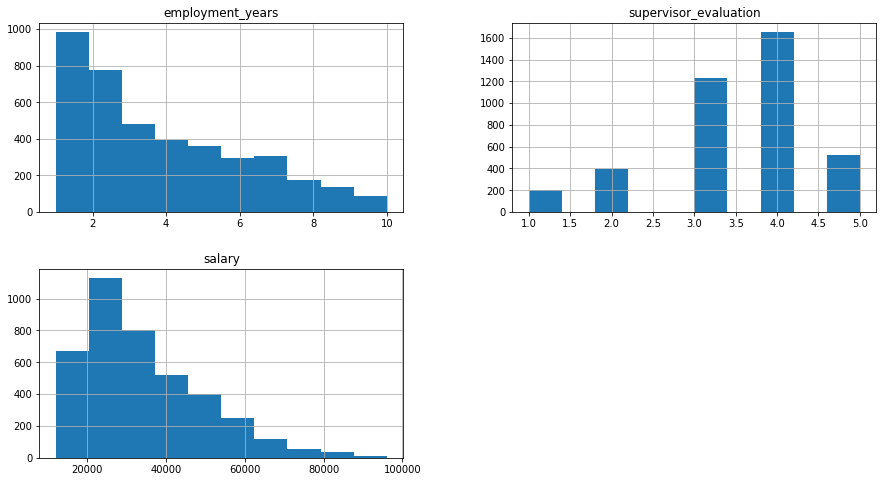

In [252]:
train_quit.drop('id', axis=1).hist(figsize=(15, 8));

**Вывод:**

В файле 'train_quit' обнаружена ошибка в слове sinior, исправила на senior.

В файле 'X_test_quit' как мы помним, есть пропущенные значения nan в столбцах dept, level, workload.

В файле 'y_test_quit' сделали сортировку по 'id'.

Во всех файлах явных дубликатов нет. Аномалий не обнаружено. Пропуски nan заполним дальше через пайплайн.

### Исследовательский анализ данных

#### Составление портрета уволившегося сотрудника.

In [253]:
train_quit.drop('id', axis=1).describe() # оценим данные с количественными значениями

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [254]:
train_quit[train_quit['quit'] == 'no'].drop('id', axis=1).describe() # оценим данные с количественными значениями

,employment_years,supervisor_evaluation,salary
count,2872.000000,2872.000000,2872.000000
mean,4.430710,3.643106,37702.228412
std,2.544635,0.965295,15218.977339
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,25200.000000
50%,4.000000,4.000000,34800.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


In [255]:
train_quit[train_quit['quit'] == 'yes'].drop('id', axis=1).describe() # оценим данные с количественными значениями

,employment_years,supervisor_evaluation,salary
count,1128.000000,1128.000000,1128.000000
mean,1.844858,3.046099,23885.106383
std,1.274920,0.973291,9351.599505
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,16800.000000
50%,1.000000,3.000000,22800.000000
75%,2.000000,4.000000,27600.000000
max,10.000000,5.000000,79200.000000


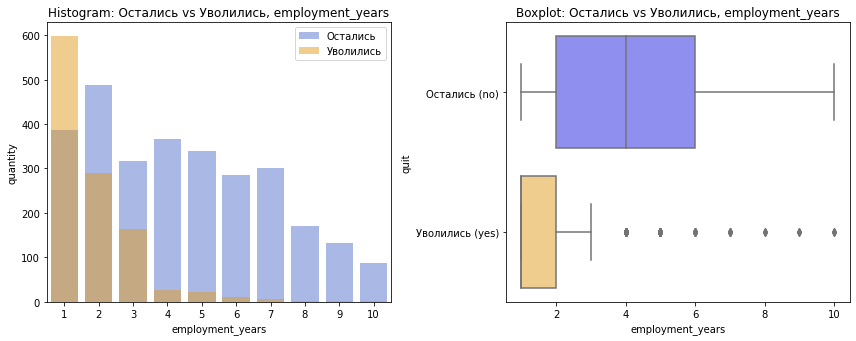

In [256]:
bar_and_box_category(train_quit, 'quit', 'employment_years')

'employment_years' распределение нормальное, те, кто уволился проработали в основном 1, 2 года (в среднем 1 год), кто остался 2 - 6 лет (в среднем 1 год); на boxplot уволившихся есть выбросы от 4 лет, единичные случаи, у тех кто остался выбросов нет.

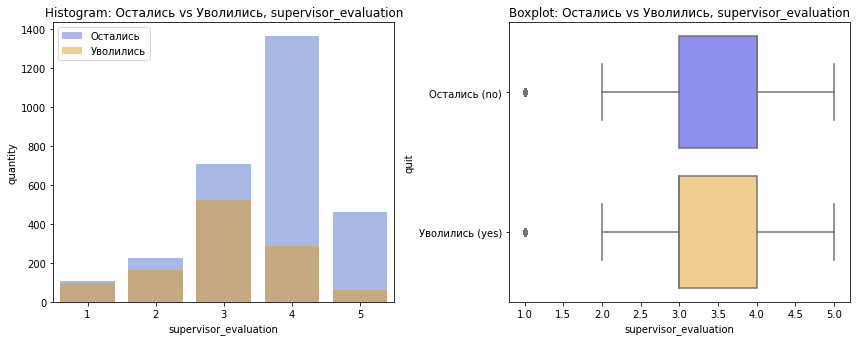

In [257]:
bar_and_box_category(train_quit, 'quit', 'supervisor_evaluation')

'supervisor_evaluation' распределение нормальное, те, кто уволился получили оценку в среднем 3, основная часть - 3 - 4, кто остался получили в среднем оценку 4 (основная часть в диапазоне 3 - 4); на обоих boxplot есть выбросы с оценкой 1.

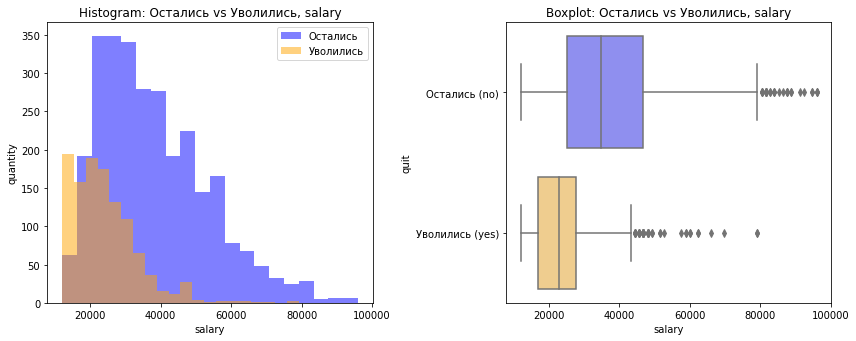

In [258]:
hist_and_box_category(train_quit, 'quit', 'salary')

'salary' распределение нормальное, те, кто уволился получали зарплату в среднем 22'800, основная часть - 16'800 - 27'600, кто остался получали в среднем - 34'800 (основная часть в диапазоне 25'200 - 46'800); на обоих boxplot есть выбросы, уволивишхся больше 43'000, оставшихся больше 80'000.

In [259]:
pie(train_quit, 'dept', 'quit')

- **'dept'** соотношение по отделам. Из отдела sales -  уволившихся 28.3%, оставшиеся - 71.7%, technology - уволившихся 29.74%, оставшиеся - 70.26%, purchasing - уволившихся 28.23%, оставшиеся - 71.77%, marketing - уволившихся 28.01%, оставшиеся - 71.99%, hr - уволившихся 25%, оставшиеся - 75%. Самый большой процент уволившихся в отделе technology 29.74%, всех меньше из отдела hr - 25%.

In [260]:
train_quit.groupby(['dept'])['quit'].value_counts(normalize=True)

dept        quit
hr          no      0.750000
            yes     0.250000
marketing   no      0.719931
            yes     0.280069
purchasing  no      0.717687
            yes     0.282313
sales       no      0.716968
            yes     0.283032
technology  no      0.702586
            yes     0.297414
Name: quit, dtype: float64

In [261]:
pie(train_quit, 'quit', 'level')

- **'level'** у большей части уволившихся сотрудников уровень 'junior' - 88.92%, у оставшихся - 32.94%, уровень 'middle' уволившихся - 9.57%, оставшихся - 55.22%, уровень 'senior' уволившихся - 1.51%, оставшихся - 11.84%.

In [262]:
pie(train_quit, 'quit', 'workload')

- **'workload'** у большей части уволившихся сотрудников нагрузка 'low' - 46.01%, у оставшихся - 23.99%, нагрузка 'medium' уволившихся - 43.26%, оставшихся - 56.75%, нагрузка 'high' уволившихся - 10.73%, оставшихся - 19.25%.

In [263]:
pie(train_quit, 'quit', 'last_year_promo')

- **'last_year_promo'** у большей части уволившихся сотрудников не было повышения - 99.91%, у оставшихся - 96.10%, было повышение уволившихся - 0.09%, оставшихся - 3.9%.

In [264]:
pie(train_quit, 'quit', 'last_year_violations')

- **'last_year_violations'** у большей части уволившихся сотрудников не было нарушения договора - 79.79%, у оставшихся - 88.96%, было нарушение договора уволившихся - 20.21%, оставшихся - 11.04%.

**Вывод:**

Уволившиеся сотрудники в основном:
- проработали в компании меньше 2 лет, 
- получили оценку качества работы от руководителя 3 (из 5), 
- получали в среднем зарплату 22'800 (в отличие от оставшихся 34'800), 
- работали на позиции 'junior', 
- имели низкую нагрузку 'low', 
- повышения за год не имели, 
- нарушения договора имели только 20% уволившихся (оставшиеся имеют нарушения договора 11%).

#### Зависимость уровня удовлетворенности на то, уволится ли сотрудник

In [265]:
# присоединим к файлу X_test_quit целевые призники из двух файлов, уровень удовлетворенности и увольнение сотрудников
X_test_rate_quit = X_test_quit.merge(y_test_rate, on='id').merge(y_test_quit, on='id')
X_test_rate_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [266]:
#показатели уровня удовлетворенности уволившихся и оставшихся сотрудников
print('Уволились')
print(X_test_rate_quit[X_test_rate_quit['quit'] == 'yes']['job_satisfaction_rate'].describe())
print('Остались')
print(X_test_rate_quit[X_test_rate_quit['quit'] == 'no']['job_satisfaction_rate'].describe())

Уволились
count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64
Остались
count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


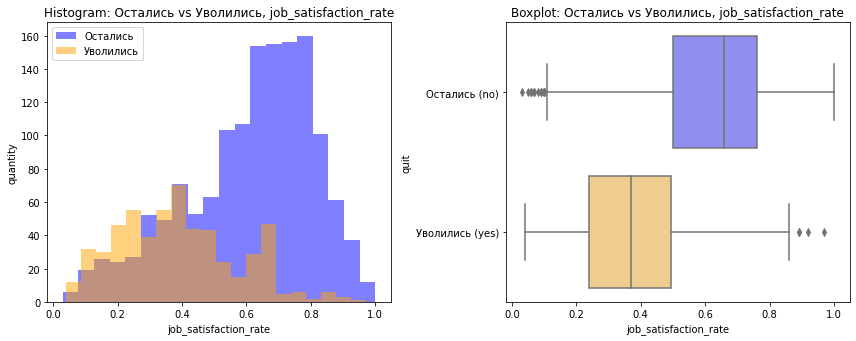

In [267]:
hist_and_box_category(X_test_rate_quit, 'quit', 'job_satisfaction_rate')

на графиках видно, что средний уровень удовлетворенности уволившихся сотрудников 0.37 (большая часть в диапазоне 0.24 - 0.49), у оставшихся среднее значение уровня удовлетворенности 0.66 (большая часть значений в диапазоне 0.5 - 0.76). Т.е. уровень удовлетворенности уволившихся сотрудников действительно влияет на желание продолжать работать в компании.

### Добавление нового входного признака

In [268]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [269]:
X_train_1 = train_quit.drop(columns=['id', 'quit'], axis=1) # удаляем лишние столбцы
y_pred_2 = grid.predict(X_train_1) # получаем предсказания с помощью обученной модели
train_quit['job_satisfaction_rate'] = y_pred_2 # добавляем столбец с предсказанием к данным
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.660000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


**Вывод:**

получили предсказания 'job_satisfaction_rate' с помощью модели grid и добавили к входным признакам тренировочной выборки train_quit.

In [270]:
X_test_rate_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no


In [271]:
X_test_2 = X_test_rate_quit.drop(columns=['id', 'job_satisfaction_rate', 'quit'], axis=1) # удаляем лишние столбцы
y_pred_3 = grid.predict(X_test_2) # получаем предсказания с помощью обученной модели
X_test_2['job_satisfaction_rate'] = y_pred_3 # добавляем столбец с предсказанием к данным
X_test_2.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,hr,junior,low,2,no,no,4,19200,0.836522
1,marketing,junior,low,4,no,no,4,16800,0.852000
2,purchasing,middle,high,5,no,no,4,55200,0.738000
3,sales,middle,medium,5,no,no,4,43200,0.824643
4,sales,middle,high,6,no,no,4,48000,0.679565


### Корреляционный анализ

In [272]:
list_no_object_columns = train_quit.drop('id', axis=1).select_dtypes(exclude=['object']).columns.tolist()
train_quit.columns.tolist()

['id',
 'dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary',
 'quit',
 'job_satisfaction_rate']

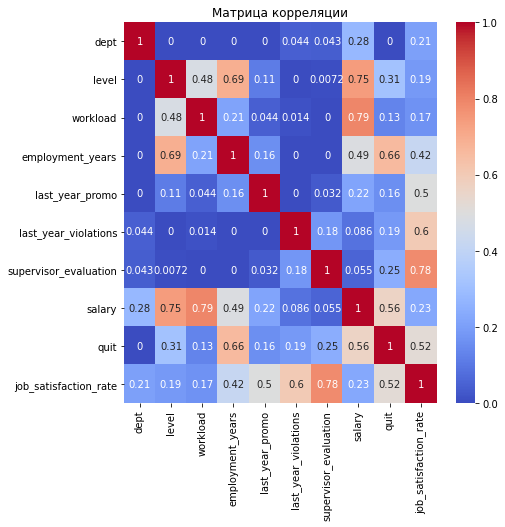

In [273]:
corr_matrix = train_quit.drop('id', axis=1).phik_matrix(interval_cols=list_no_object_columns)
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Согласно шкале Чеддока и коэффициентам корреляции определена взаимосвязь целевого признака 'quit' со следующими признаками:

- сильная  зависимость (0.7 - 0.9)
        нет

- средняя зависимость (0.5 - 0.7)
        'employment_years' длительность работы (corr= 0.66)
        'salary' зарплата (corr= 0.56)
        'job_satisfaction_rate' уровень удовлетворенности (corr= 0.53)
                
- слабая зависимость (0.3 - 0.5)
        'level' должность (corr= 0.31)

- очень слабая зависимость (0 - 0.3)
        'workload' загруженность (corr= 0.13)
        'last_year_promo' повышение (corr= 0.16)
        'last_year_violations' нарушение договора (corr=0.19)
        'supervisor_evaluation' оценка руководителя (corr=0.25)
        
- нет зависимости
        'dept' отдел (corr= 0)

### Подготовка данных

In [276]:
# подготовим выборки
X_train_2 = train_2.drop('quit', axis=1)
y_train_2 = train_2['quit']
X_test_2 = X_test_rate_quit.drop('id', axis=1)
y_test_2 = y_test_quit['quit']

In [277]:
X_train_2.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [278]:
label_encoder = LabelEncoder()

y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [279]:
dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

{'no': 0, 'yes': 1}

In [280]:
ohe_columns = [
    'dept', 
    'last_year_promo', 
    'last_year_violations'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
    'job_satisfaction_rate'
]

In [281]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [282]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [283]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [284]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [285]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

### Обучение моделей

In [286]:
grid_2 = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

grid_2.fit(X_train_2, y_train_2)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.9/site-packages/sklearn/lin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                          'models__n_neighbors': range(1, 20),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(2, 21),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [288]:
pd.set_option('display.max_colwidth', None)
result_2 = pd.DataFrame(grid_2.cv_results_)
result_2[['rank_test_score', #'param_models',
        'mean_test_score','params', 
       ]].sort_values('rank_test_score').head(10)

,rank_test_score,mean_test_score,params
39,1,0.927528,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 14, 'preprocessor__num': StandardScaler()}"
54,2,0.927303,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 19, 'preprocessor__num': StandardScaler()}"
36,3,0.927045,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 13, 'preprocessor__num': StandardScaler()}"
45,4,0.927028,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 16, 'preprocessor__num': StandardScaler()}"
51,5,0.926869,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 18, 'preprocessor__num': StandardScaler()}"
42,6,0.926851,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 15, 'preprocessor__num': StandardScaler()}"
30,7,0.926349,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 11, 'preprocessor__num': StandardScaler()}"
33,8,0.926256,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 12, 'preprocessor__num': StandardScaler()}"
48,9,0.926218,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 17, 'preprocessor__num': StandardScaler()}"
21,10,0.925227,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 8, 'preprocessor__num': StandardScaler()}"


In [112]:
grid_2.best_params_

{'models': KNeighborsClassifier(),
 'models__n_neighbors': 14,
 'preprocessor__num': StandardScaler()}

In [113]:
'Метрика ROC-AUC для лучшей модели:\n', grid_2.best_score_

('Метрика ROC-AUC для лучшей модели:\n', 0.9275283304323396)

In [114]:
y_pred_2 = grid_2.predict_proba(X_test_2)
f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_2, y_pred_2[:, 1]), 4)}'

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



'Метрика ROC-AUC на тестовой выборке: 0.9207'

**Вывод:**

Лучшей моделью из трех (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression) стала KNeighborsClassifier() c метрикой ROC-AUC=0.93, на тестовой выборке ROC-AUC=0.92. Модель лучше справилась, потому что признаки имеют чёткую кластеризацию, мало выбросов.

## Выводы

Были поставлены две задачи.

**Задача 1** предсказание уровня удовлетворённости сотрудника. Для решения задачи были выполнены следующие шаги:

- предобработка данных, в ходе которой исправлены ошибки в sinior на senior, заменены пропущенные значения ' ' на nan, выявлено, что явных дубликатов и аномалий в файлах нет.


- исследовательский анализ показал, что в среднем все сотрудники работают 2-6 лет, имеют оценку качества работы от руководителя 4 (из 5), получают зарплату в диапазоне 22'800 - 43'200, среднее значение уровня удовлетворенности 0.56, основная часть в диапазоне 0.36 - 0.71. Также сотрудники распределены:
    - большая часть сотрудников работает в отделе 'sales' - 38%, 'technology' - 22%, 'purchasing' - 15%, 'marketing' - 14%, 'hr' - 11%; 
    - большая часть сотрудников занимает уровнь 'junior' - 47%, 'middle' - 44%, 'senior' - 9%;
    - у большей части сотрудников нагрузка 'medium' - 52%, 'low' - 30%, 'high - 18%;
    - за год повышение было только у 3% сотрудников, у 97% повышения не было.
    - не нарушали трудовой договор 86% сотрудников, 14% нарушали.
    
    
- корреляционный анализ выявил взаимосвязь целевого признака 'job_satisfaction_rate' от остальных:
    - сильная  зависимость от оценки руководителя (corr=0.76), 
    - средняя зависимость от нарушения договора (corr=0.56), 
    - слабая зависимость от длительности работы (corr= 0.33), 
    - очень слабая зависимость от отдела (corr= 0.082), должности (corr= 0.081), загруженности (corr= 0.056), повышения (corr= 0.019), зарплаты (corr= 0.17)
    
    
- проведена подготовка данных и обучена модель для предсказания уровня удовлетворенности сотрудника.


- получены предсказания с помощью лучшей модели DecisionTreeRegressor, значение метрики SMAPE на тестовой выборке составило 14.42(что соответствует требованию SMAPE<=15).


**Задача 2** предсказание увольнения сотрудника из компании. Для решения задачи были выполнены следующие шаги:

- предобработка данных, в ходе которой исправлены ошибки в sinior на senior, выявлено, что явных дубликатов и аномалий в файлах нет.


- исследовательский анализ **уволившихся** сотрудников показал, что 
    - в среднем работают до 2 лет,
    - получили оценку качества работы от руководителя 3 (из 5), 
    - получали в среднем зарплату 22'800 (в отличие от оставшихся 34'800), 
    - работали на позиции 'junior' 89% (в отличие от оставшихся 33%)
    - имели низкую нагрузку 'low' 46% (в отличие от оставшихся 24%)
    - повышения за год не имели 99.91%, у оставшихся - 96%
    - нарушения договора имели только 20% уволившихся (оставшиеся имеют нарушения договора 11%).
    
    
- выявлена зависимость уровня удовлетворенности от того, что сотрудник уволится. Средний уровень удовлетворенности уволившихся сотрудников 0.37 (большая часть в диапазоне 0.24 - 0.49), у оставшихся среднее значение уровня удовлетворенности 0.66 (большая часть значений в диапазоне 0.5 - 0.76).


 - корреляционный анализ выявил взаимосвязь целевого признака 'quit' от остальных:
    - средняя зависимость от длительности работы (corr= 0.66), зарплаты (corr= 0.56), уровеня удовлетворенности (corr= 0.53),
    - слабая зависимость от должности (corr= 0.31), 
    - очень слабая зависимость от загруженности (corr= 0.13), повышения (corr= 0.16), нарушения договора (corr=0.19), оценки руководителя (corr=0.25), 
    - нет зависимости от отдела (corr= 0)
    
    
- проведена подготовка данных и обучена модель для предсказания уволится сотрудник или нет.


- получены предсказания с помощью лучшей модели KNeighborsClassifier, значение метрики ROC-AUC на тестовой выборке составило 0.92 (что соответствует требованию ROC-AUC>=0.91).


**Предложения:** уволится или останется сотрудник напрямую зависит от его уровня удовлетворенности. Чтобы повысить уровень удовлетворенности можно провести курсы повышения квалификации для сотрудников уровня 'junior', что также повлияет на оценку качества работы руководителем, повысить 'отличившихся' до уровня 'middle', увеличить зарплату. Также рассмотреть возможность брать более опытных сотрудников уровня 'middle'.